In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q

In [33]:
# plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
device = "cpu"

In [34]:

outfile_name = f"angularity_2_test"

with open(f"output_final/{outfile_name}", "rb") as ifile:
    save_dict = pickle.load(ifile)
# load in data

losses = save_dict["loss"]
g_coeffs_log = save_dict["g_coeffs"]
theta_log = save_dict["theta"]


# save_dict = {}

# with open(f"output_final/{outfile_name}_config", "rb") as ifile:
#     save_dict["configs"] = pickle.load(ifile)
   
# losses = np.load(f"output_final/{outfile_name}_losses.npy")
# g_coeffs_log = np.load(f"output_final/{outfile_name}_g_coeffs.npy")
# theta_log = np.load(f"output_final/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]


print(save_dict["configs"])

{'distribution': 'angularity', 'order_to_match': 2, 'name': 'test', 'mstar': 1, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': False, 'ratio_loss': False, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'epochs': 30000, 'batch_size': 512, 'lr': 0.01, 'seed': 42, 'm': 3, 'n': 3}


In [35]:
run_toy = True


In [36]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = torch.tensor([math.factorial(k) for k in range(max_N)], device=device).float()
factorial_cache_m = torch.tensor([math.factorial(k) for k in range(max_M)], device=device).float()
n_range = torch.arange(max_N, device=device)
m_range = torch.arange(1, max_M, device=device)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



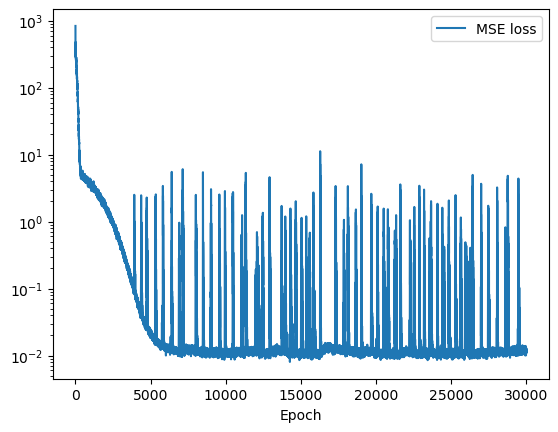

In [37]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



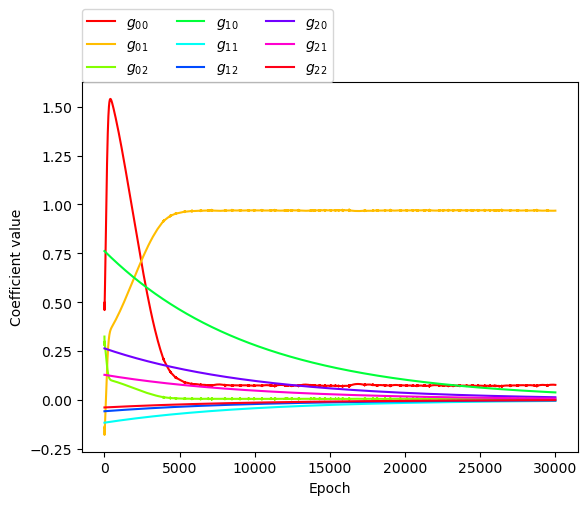

In [38]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



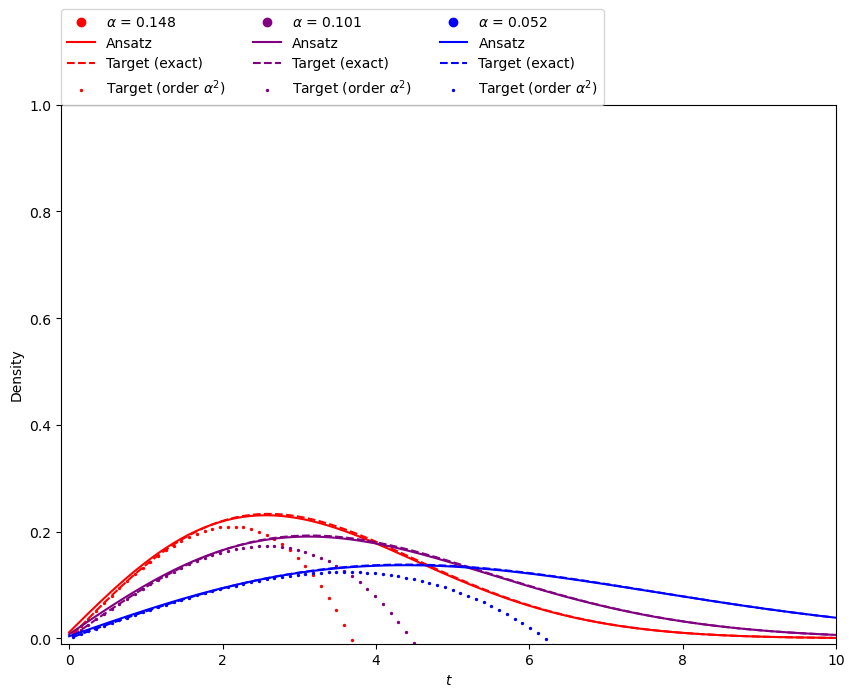

In [39]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])


if not run_toy:  # only needs to be done once
    data_dict = read_in_data([2], distribution, t_bins, device)
    #print(data_dict.keys())



tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue"]


plt.figure(figsize = (10, 7))
for i, alpha in enumerate([0.148, 0.101, 0.052]):
    alpha_tensor = torch.tensor(alpha, device=device)
    plt.scatter( 100, 100, label=f"$\\alpha$ = {alpha}",  color=colors[i])



    plt.plot(  
       tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1]).to(device), torch.tensor(theta_log[-1]).to(device), save_dict["configs"]["mstar"], save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], device, factorial_cache_info), label="Ansatz",  color=colors[i],
    )

    if run_toy:
        plt.plot(
            t_bin_centers.detach().cpu().numpy(),
            get_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach().cpu().numpy(), label="Target (exact)", color=colors[i],  linestyle="dashed",
        )
        plt.scatter(
            t_bin_centers.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, distribution, t_bin_centers,order_to_match,device) .detach().cpu() .numpy(), 
            label=f"Target (order $\\alpha^{order_to_match}$)",  color=colors[i],  s=2,
        )
        
    else:
        alpha_string = "alpha_" + str(int(1000 * alpha)).zfill(4)
        plt.plot(t_bin_centers.detach().cpu().numpy(),data_dict[alpha_string].detach().cpu().numpy(),label="Target (data)",color=colors[i], linestyle="dotted",)
        #plt.plot(tt.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, "LO_thrust", tt, -1, device).detach() .cpu().numpy(),label="Target (exact)", color=colors[i],linestyle="dashed",
       # )
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

In [40]:
plt.figure()
plt.plot(
            t_bin_centers.detach().cpu().numpy(),
            get_pdf_toy( torch.tensor(0.03, device=device)
, "LO_thrust", t_bin_centers, 2, device).detach().cpu().numpy(), label="Target (exact)", color=colors[i],  linestyle="dashed",
        )
#plt.plot(
 #           t_bin_centers.detach().cpu().numpy(),
 #           get_pdf_toy( torch.tensor(0.003, device=device)
#, "LO_thrust", t_bin_centers, 1, device).detach().cpu().numpy(), label="Target (exact)", color=colors[i],  linestyle="dashed",
#        )
plt.xlim(0, 10)
plt.show()


NameError: name 'C_F' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:

N_C = 3
N_F = 5

C_F = (N_C**2 - 1) / (2 * N_C) # Quark Casimir, 4/3
C_A = N_C # Gluon Casimir, 3
T_F = 1/2 

zeta_3 = 1.20205690315959

MZ = 91.1876 # GeV
MW = 80.379 # GeV
MH = 125.18 # GeV
MT = 173.21 # GeV


alpha_s_MZ = 0.1181


beta0 = (11 * N_C - 4 * T_F * N_F) / 3
beta1 = (34 * N_C**2 - 20 * C_A * T_F * N_F - 12 * C_F * T_F * N_F ) / 3


def running_coupling(alpha_0, mu0, mu):
    """
    Running coupling constant at scale mu, given the coupling at scale mu0.
    """
    return alpha_0 / (1 + beta0 * alpha_0 * np.log(mu / mu0) / (2 * np.pi))




def DA(t):
    return(-3 + 4 * t ) * C_F

def DB(t):

    term1 = (1/4) * (9 + 8 * np.pi**2 * (-1 + 2 * t) - 4 * t * (13 + 2 * t * (-9 + 4 * t)) + 16 * zeta_3) * C_F**2
    term2 = (-1/9) * (-45 + 22 * t + 36 * t**2) * C_F * N_F * T_F
    term3 = (1/36) * (-513 + 338 * t - 24 * np.pi**2 * t + 396 * t**2 + 216 * zeta_3) * C_A * C_F
    
    
    return term1 + term2 + term3

def D(x, alpha, params, order = 1):

    scale = 91.1876 * x
    alpha_s = running_coupling(alpha, alpha_s_MZ, alpha_s_MZ)


    funcs = [DA, DB, ]
    alpha_bar = alpha_s / (2 * np.pi)
    
    res = np.zeros_like(x)

    x = x + np.log(2)

    for o in range(order):
        res += alpha_bar**(o + 1) * funcs[o](x)
    return res

In [ ]:
t = np.linspace(0, 10, 100)

plt.figure()
plt.plot(x, D(x, 0.1, None, order = 2))
plt.xlabel("t")
plt.ylabel("Density")
plt.show()